In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

### 1.Data Preprocessing

In [3]:
train = pd.read_csv(r'C:\Users\User\Documents\Code\ML\MLP_From_Scratch\data\train.csv')
test = pd.read_csv(r'C:\Users\User\Documents\Code\ML\MLP_From_Scratch\data\test.csv')
df_train = train.copy().drop('ID_code', axis=1)
df_test = test.copy().drop('ID_code', axis=1)
df_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 306.7 MB


#### Handle missing values

In [5]:
print(df_train.isna().sum().values.any())
print(df_test.isna().sum().values.any())

False
False


In [6]:
df_train['target'].value_counts(normalize=True)

target
0    0.89951
1    0.10049
Name: proportion, dtype: float64

#### Feature Engineering

In [7]:
def feature_engineering(df):
    df = df.copy()
    features = [col for col in df.columns if col != 'target']
    df['sum']  = df[features].sum(axis=1)  
    df['min']  = df[features].min(axis=1)
    df['max']  = df[features].max(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['std']  = df[features].std(axis=1)
    df['med']  = df[features].median(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)
df_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_198,var_199,sum,min,max,mean,std,med,skew,kurt
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,6.77040,0.101580,1.331023
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,7.22315,-0.351734,4.110215
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,5.89940,-0.056957,0.546438
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,6.70260,-0.480116,2.630499
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,6.94735,-1.463426,9.787399


#### Standardization

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform="pandas")
X_train = df_train.drop('target', axis=1)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(df_test)
y_train = df_train['target']

### 2.Training

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_pred, y_true):
    y_pred_binary = (y_pred >= 0.5).astype(int)
    y_true = y_true.to_numpy().reshape(-1, 1)
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    return roc_auc, accuracy, precision, recall, f1

In [10]:
from model import MLP
from sklearn.model_selection import StratifiedKFold

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
dropout_rates = [0.1, 0.25, 0.5, 0.75]
results = []
for dropout_rate in dropout_rates:
    roc_aucs, accuracies, precisions, recalls, f1s = [], [], [], [], []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, df_train['target'])):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        clf = MLP(X_train_fold, y_train_fold, 0.005, dropout_rate, verbose=False)
        clf.train(256, 50, X_val_fold, y_val_fold)
        roc_auc, accuracy, precision, recall, f1 = evaluate(clf.predict(X_val_fold), y_val_fold)
        roc_aucs.append(roc_auc)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    results.append({
        'Dropout Rate': dropout_rate,
        'Average ROC-AUC': f"{np.mean(roc_aucs):.4f}",
        'Average Accuracy': f"{np.mean(accuracies):.4f}",
        'Average Precision': f"{np.mean(precisions):.4f}",
        'Average Recall': f"{np.mean(recalls):.4f}",
        'Average F1-Score': f"{np.mean(f1s):.4f}"
    })
df_results = pd.DataFrame(results)
print(df_results)

   Dropout Rate Average ROC-AUC Average Accuracy Average Precision  \
0          0.10          0.8554           0.9138            0.6575   
1          0.25          0.8605           0.9151            0.6952   
2          0.50          0.8652           0.9150            0.7288   
3          0.75          0.8658           0.9057            0.8874   

  Average Recall Average F1-Score  
0         0.2972           0.4093  
1         0.2768           0.3960  
2         0.2450           0.3666  
3         0.0752           0.1328  


Fold 1/5
Epoch 1/50, Train Loss: 0.3163, Val Loss: 0.2471
Epoch 10/50, Train Loss: 0.2620, Val Loss: 0.2378
Epoch 20/50, Train Loss: 0.2570, Val Loss: 0.2346
Epoch 30/50, Train Loss: 0.2552, Val Loss: 0.2345
Epoch 40/50, Train Loss: 0.2547, Val Loss: 0.2334
Epoch 50/50, Train Loss: 0.2530, Val Loss: 0.2333
Fold 2/5
Epoch 1/50, Train Loss: 0.3223, Val Loss: 0.2547
Epoch 10/50, Train Loss: 0.2629, Val Loss: 0.2437
Epoch 20/50, Train Loss: 0.2583, Val Loss: 0.2389
Epoch 30/50, Train Loss: 0.2565, Val Loss: 0.2391
Epoch 40/50, Train Loss: 0.2547, Val Loss: 0.2385
Epoch 50/50, Train Loss: 0.2556, Val Loss: 0.2378
Fold 3/5
Epoch 1/50, Train Loss: 0.3406, Val Loss: 0.2491
Epoch 10/50, Train Loss: 0.2591, Val Loss: 0.2383
Epoch 20/50, Train Loss: 0.2552, Val Loss: 0.2370
Epoch 30/50, Train Loss: 0.2526, Val Loss: 0.2373
Epoch 40/50, Train Loss: 0.2515, Val Loss: 0.2363
Epoch 50/50, Train Loss: 0.2510, Val Loss: 0.2353
Fold 4/5
Epoch 1/50, Train Loss: 0.3203, Val Loss: 0.2479
Epoch 10/50, Train

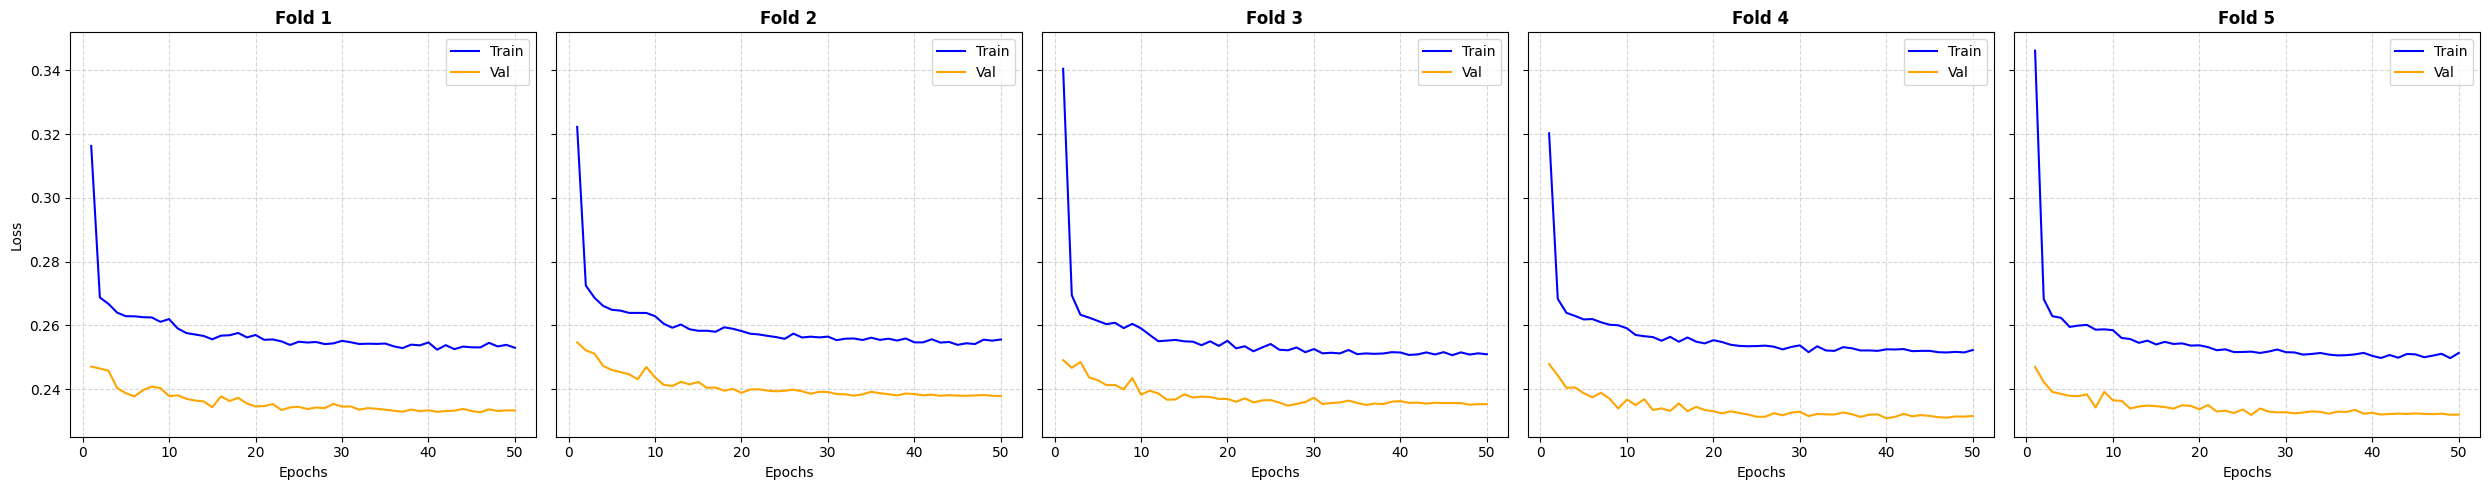

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
roc_aucs, accuracies, precisions, recalls, f1s = [], [], [], [], []
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, df_train['target'])):
    print(f"Fold {fold + 1}/{n_splits}")
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    clf = MLP(X_train_fold, y_train_fold, 0.005, 0.75)
    clf.train(256, 50, X_val_fold, y_val_fold)
    roc_auc, accuracy, precision, recall, f1 = evaluate(clf.predict(X_val_fold), y_val_fold)
    roc_aucs.append(roc_auc)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    train_losses, val_losses = clf.get_losses()
    epochs = range(1, len(train_losses) + 1)
    ax = axes[fold]
    ax.plot(epochs, train_losses, label='Train', color='blue')
    ax.plot(epochs, val_losses, label='Val', color='orange')
    ax.set_title(f'Fold {fold + 1}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epochs')
    if fold == 0: ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
print(f"Average ROC-AUC: {np.mean(roc_aucs):.4f}")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1-Score: {np.mean(f1s):.4f}")

Average ROC-AUC: 0.8658
Average Accuracy: 0.9081
Average Precision: 0.8579
Average Recall: 0.1080
Average F1-Score: 0.1866


In [17]:
clf = MLP(X_train, y_train, 0.005, 0.75)
clf.train(256, 50, X_train, y_train)

Epoch 1/50, Train Loss: 0.3129, Val Loss: 0.2473
Epoch 10/50, Train Loss: 0.2604, Val Loss: 0.2355
Epoch 20/50, Train Loss: 0.2560, Val Loss: 0.2362
Epoch 30/50, Train Loss: 0.2544, Val Loss: 0.2339
Epoch 40/50, Train Loss: 0.2535, Val Loss: 0.2327
Epoch 50/50, Train Loss: 0.2541, Val Loss: 0.2327


In [18]:
y_test_pred = clf.predict(X_test)
submission = pd.DataFrame({'ID_code': test['ID_code'], 'target': y_test_pred.flatten()})
submission.to_csv(r'C:\Users\User\Documents\Code\ML\MLP_From_Scratch\data\submission.csv', index=False)